# Big 5 Personality Clustering Project
By: Greg Maggard

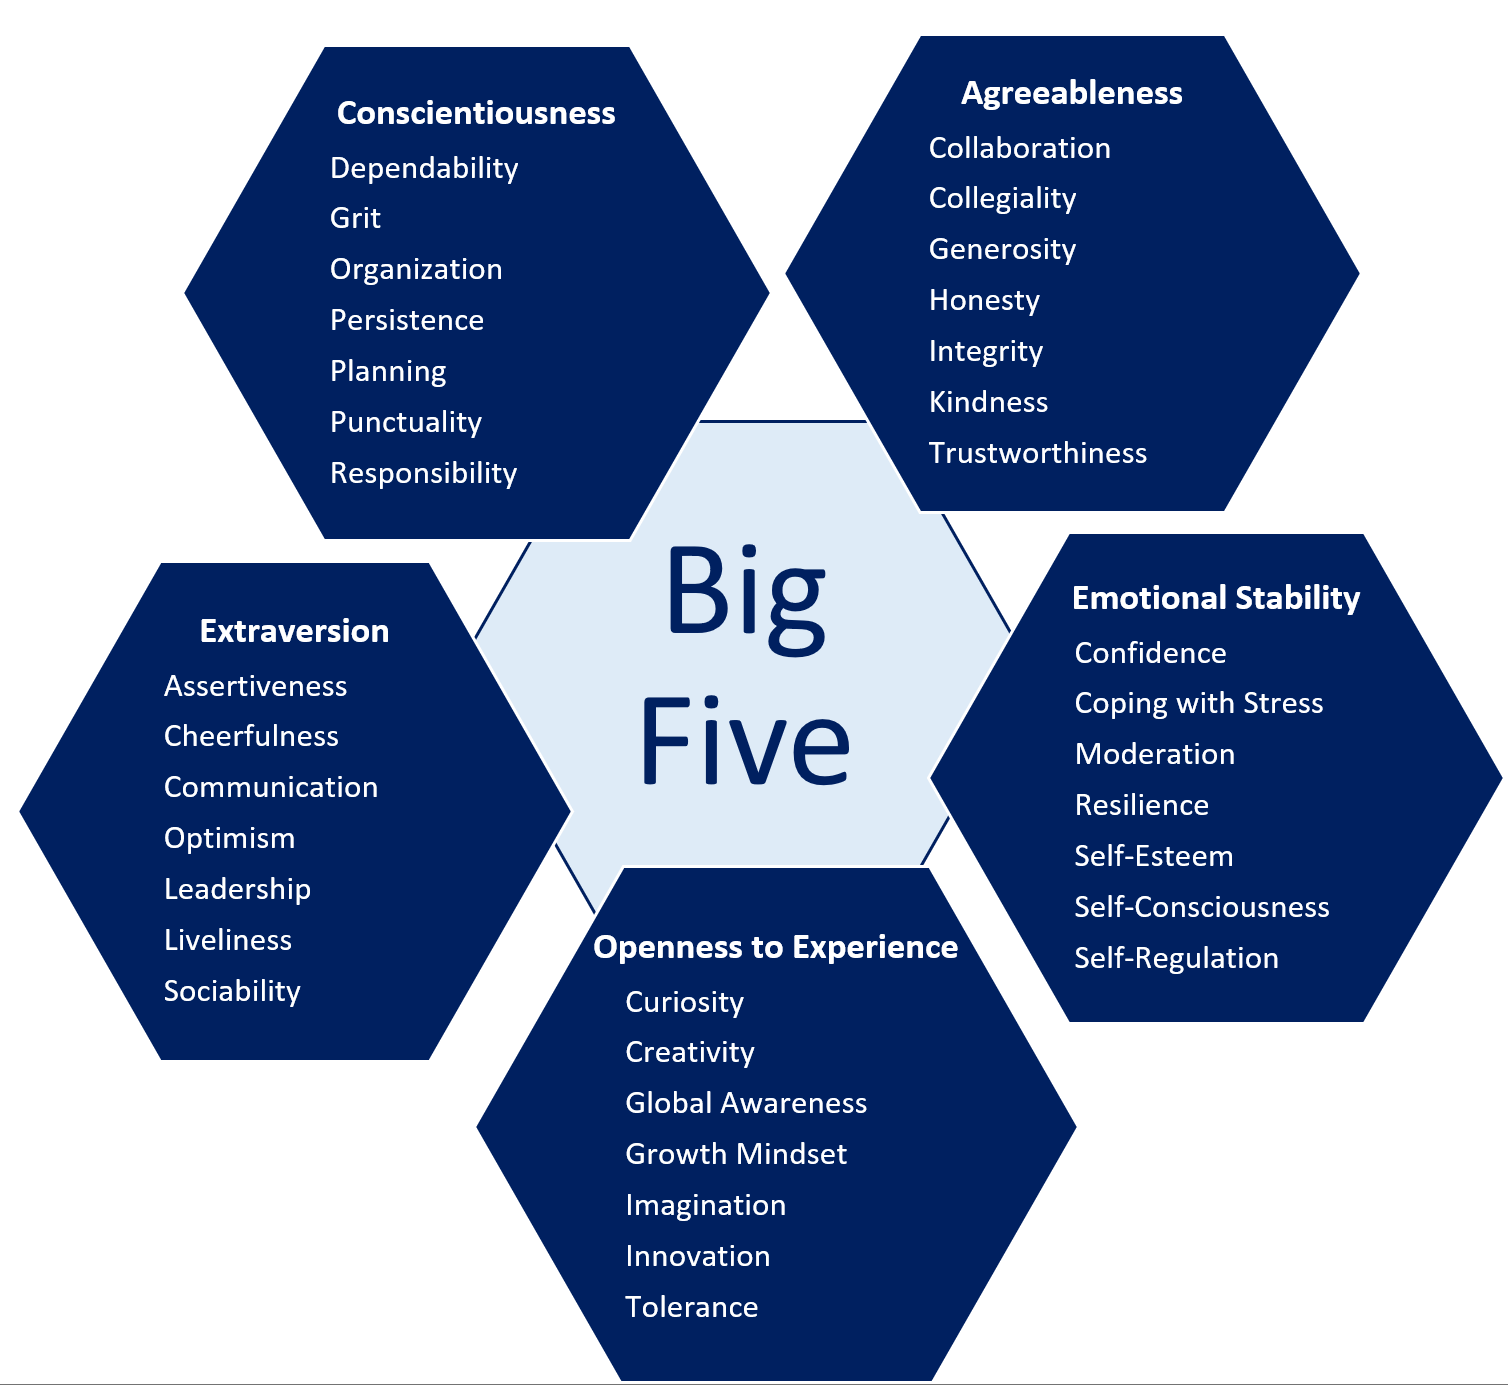

## Introduction:

#### Goals and Objectives:

This project intends to use K-Means clustering to identify the number and nature of potential personality groupings that may be found in user responses to a personality metric, which is based on the [Big 5 Personality Model](https://en.wikipedia.org/wiki/Big_Five_personality_traits). The Big 5 Model is also often called the "OCEAN" model, due to the acronym created from the 5 measured characteristics.

#### The Data:

This dataset was acquired from Kaggle, and can be found [here](https://www.kaggle.com/datasets/tunguz/big-five-personality-test).

The [Big 5 Personality Questionnaire](https://openpsychometrics.org/tests/IPIP-BFFM/), as presented on the Open-Source Pscyhometrics Project site, asks its users 50 questions, with 10 questions each dedicated to the following categories:
- Openness (OPN)
- Conscientiousness (CSN)
- Extroversion (EXT)
- Agreeableness (AGR)
- Emotional Stability (EST) 
    - *Note: This verbiage refers to the metric more commonly titled "Neuroticism."*

## Wrangling:

#### Key Takeaways During the Wrangling Process:

1. The data was acquired from a CSV of around 1M responses found on Kaggle. 
2. Columns containing metadata about user, includings things like how long it took the user to select each answer, their computer screen size, and their estimated latitudinal/longitudinal location were eliminated. 
3. Responses that contained either null values or '0.0', indicating no response, were eliminated. 
4. For the sake of data integrity, responses that came from non-unique IP addresses were eliminated. This was a fairly large chunk of the data, but over 600,000 responses remained for analysis.
5. Since clustering is an unsupervised machine learning process, no train/validate/test split is necessary.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

import wrangle
import explore
import model

#### Data Acquisition:

The [wrangle.py](https://github.com/greg-maggard/big_5_project/blob/main/wrangle.py) script was used to do convert the contents of the downloaded CSV file into a DataFrame using Pandas.

In [2]:
df = wrangle.acquire_big_5_data()
df.head(3)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833


#### Preparing Data:

As part of the data preparation process, the following steps were completed:
   - Dropping columns not needed for analysis, including user metadata.
   - Converting '0.0' responses to null and dropping all rows containing null values.
   - Dropping all responses that came from non-unique IP addresses, and dropping column containing IP info.

In [3]:
df = wrangle.prep_big_5_data(df)
df.head(3)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,1.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,5.0,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0


In [31]:
df.shape[0]

603322

## Exploration:

#### Questions Considered:
- How are each of these questions answered on average, and what does the average person's result from this questionnaire look like? 
- Are these metrics related to one another - is being high in one associated with being low in another?

#### Key Exploration Summary and Takeaways:
- Reverse coded questions, highlighted in <span style='color:purple'>purple</span>, do appear to have inverse distributions to the regularly-coded questions. This would seem to indicate that they are for the most part measuring a similar trait.
- On average, respondents were lower in extroversion and neuroticism, slightly higher in conscientiousness and agreeableness, and highest in openness to experience. 

In [4]:
# Creating dictionaries that list the question IDs in columns as keys, with their corresponding text as values:

extroversion = {"EXT1" : "I am the life of the party.",
"EXT2" : "I don't talk a lot.",
"EXT3" : "I feel comfortable around people.",
"EXT4" : "I keep in the background.",
"EXT5" : "I start conversations.",
"EXT6" : "I have little to say.",
"EXT7" : "I talk to a lot of different people at parties.",
"EXT8" : "I don't like to draw attention to myself.",
"EXT9" : "I don't mind being the center of attention.",
"EXT10" : "I am quiet around strangers."}

neuroticism = {"EST1" : "I get stressed out easily.",
"EST2" : "I am relaxed most of the time.",
"EST3" : "I worry about things.",
"EST4" : "I seldom feel blue.",
"EST5" : "I am easily disturbed.",
"EST6" : "I get upset easily.",
"EST7" : "I change my mood a lot.",
"EST8" : "I have frequent mood swings.",
"EST9" : "I get irritated easily.",
"EST10" : "I often feel blue."}

agreeableness = {"AGR1" : "I feel little concern for others.",
"AGR2" : "I am interested in people.",
"AGR3" : "I insult people.",
"AGR4" : "I sympathize with others' feelings.",
"AGR5" : "I am not interested in other people's problems.",
"AGR6" : "I have a soft heart.",
"AGR7" : "I am not really interested in others.",
"AGR8" : "I take time out for others.",
"AGR9" : "I feel others' emotions.",
"AGR10" : "I make people feel at ease."}
           
conscientiousness = {"CSN1" : "I am always prepared.",
"CSN2" : "I leave my belongings around.",
"CSN3" : "I pay attention to details.",
"CSN4" : "I make a mess of things.",
"CSN5" : "I get chores done right away.",
"CSN6" : "I often forget to put things back in their proper place.",
"CSN7" : "I like order.",
"CSN8" : "I shirk my duties.",
"CSN9" : "I follow a schedule.",
"CSN10" : "I am exacting in my work."}

openness = {"OPN1" : "I have a rich vocabulary.",
"OPN2" : "I have difficulty understanding abstract ideas.",
"OPN3" : "I have a vivid imagination.",
"OPN4" : "I am not interested in abstract ideas.",
"OPN5" : "I have excellent ideas.",
"OPN6" : "I do not have a good imagination.",
"OPN7" : "I am quick to understand things.",
"OPN8" : "I use difficult words.",
"OPN9" : "I spend time reflecting on things.",
"OPN10" : "I am full of ideas."}

In [5]:
# Identifying which questions are reverse-coded:
reverse_coded = ["EXT2","EXT4","EXT6","EXT8","EXT10","EST2","EST4","AGR1","AGR3","AGR5","AGR7","CSN2","CSN4","CSN6","CSN8","OPN2","OPN4","OPN6"]

### Plotting Answers by Metric:

Takeaway:
- Reverse coded questions, highlighted in <span style='color:purple'>purple</span>, do appear to have inverse distributions to the regularly-coded questions.
- Some of these metrics appear to show substantial positive or negative correlations with one another (e.g. using a correlation heatmap, Agreeableness and Extroversion appear to have a fairly high positive correlation with one another).

#### Openness to Experience:

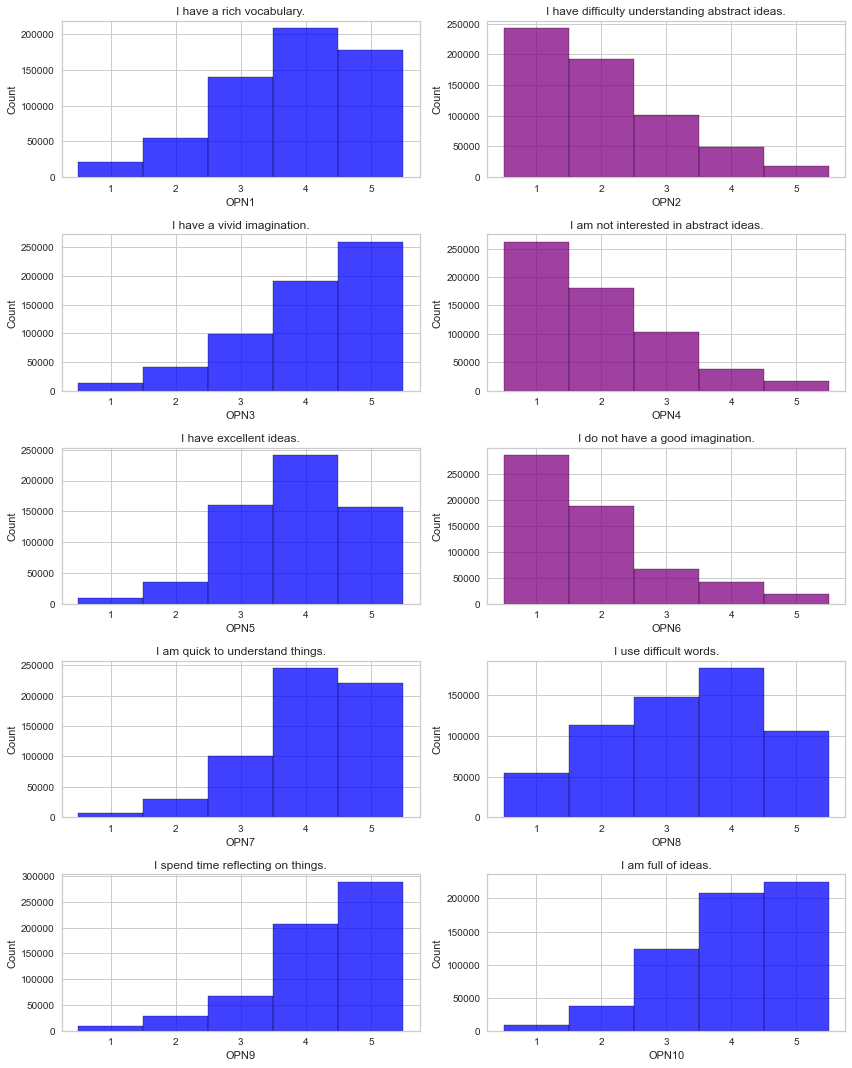

In [6]:
#Plotting Answers to Openness Questions:

keys = list(openness.keys())
#Binning values so distributions fit:
bins = [.5,1.5,2.5,3.5,4.5,5.5]

plt.figure(figsize = (12,15))
for count, i in enumerate(keys):
    #Setting Color for Regular Questions:
    if i in reverse_coded:
        rs = 'purple'
    #Setting Color for Reverse-Coded Questions;
    else:
        rs = 'blue'
    #Organizing Plots Into 5 Rows and Two Columns:
    plt.subplot(5, 2, count + 1)
    #Drawing histogram of distributions, binned to set columns on integers, and colored to show revers-coding:
    sns.histplot(data = df[i].astype(int), bins=bins, color = rs).set(title = openness[i]);

#Grouping plots neatly in final layout:
plt.tight_layout();

#### Conscientiousness:

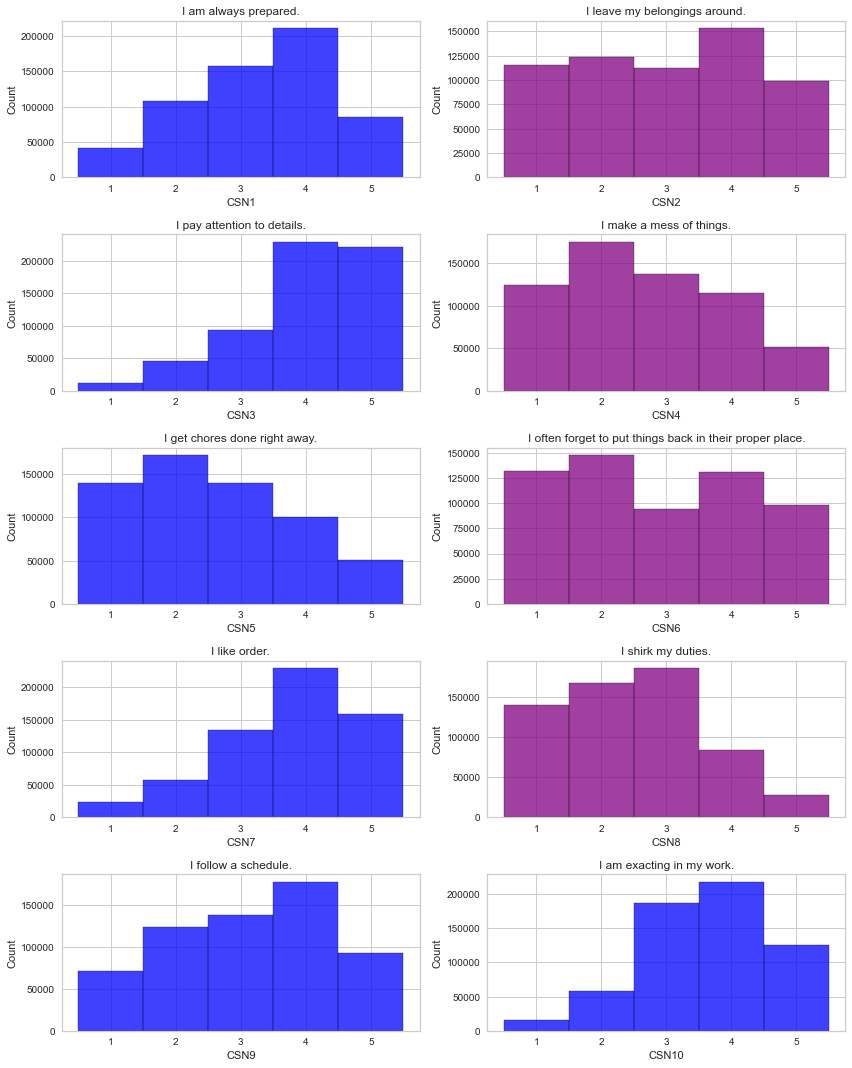

In [7]:
#Plotting Answers to Conscientiousness Questions:

keys = list(conscientiousness.keys())
#Binning values so distributions fit:
bins = [.5,1.5,2.5,3.5,4.5,5.5]

plt.figure(figsize = (12,15))
for count, i in enumerate(keys):
    #Setting Color for Regular Questions:
    if i in reverse_coded:
        rs = 'purple'
    #Setting Color for Reverse-Coded Questions;
    else:
        rs = 'blue'
    #Organizing Plots Into 5 Rows and Two Columns:
    plt.subplot(5, 2, count + 1)
    #Drawing histogram of distributions, binned to set columns on integers, and colored to show revers-coding:
    sns.histplot(data = df[i].astype(int), bins=bins, color = rs).set(title = conscientiousness[i]);

#Grouping plots neatly in final layout:
plt.tight_layout();

#### Extroversion:

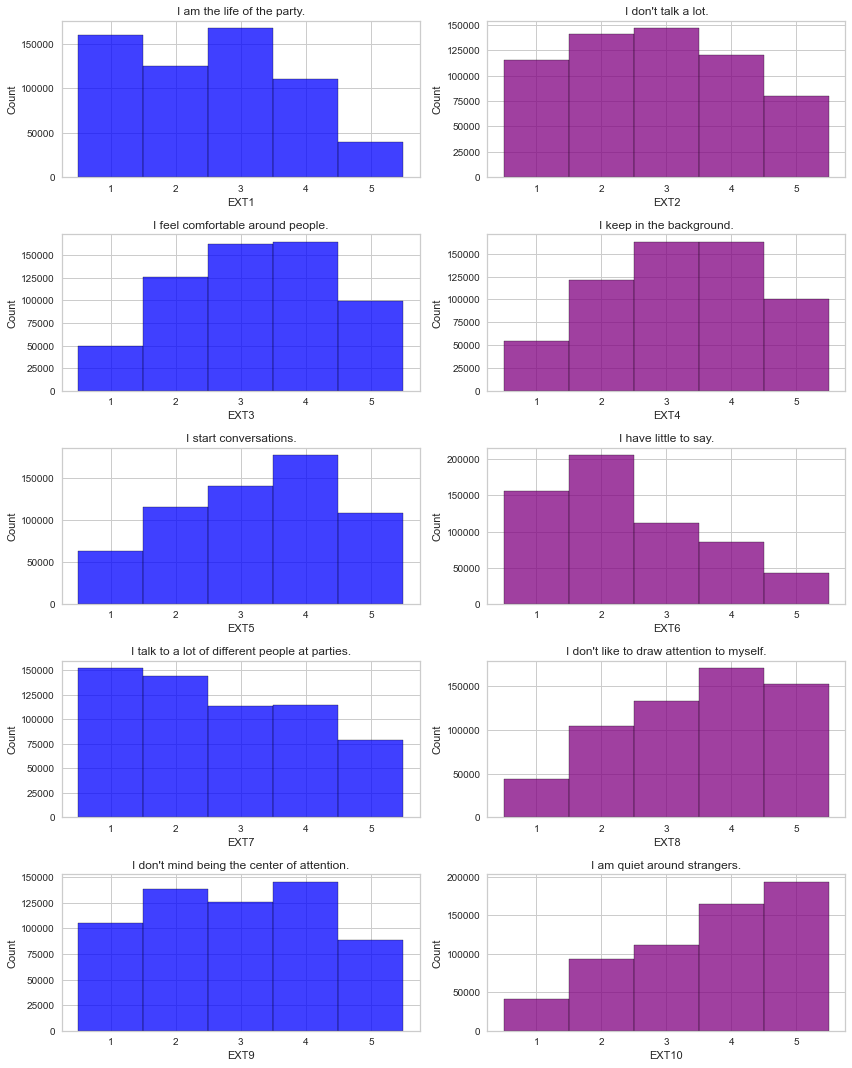

In [8]:
#Plotting Answers to Extroversion Questions:

keys = list(extroversion.keys())
#Binning values so distributions fit:
bins = [.5,1.5,2.5,3.5,4.5,5.5]

plt.figure(figsize = (12,15))
for count, i in enumerate(keys):
    #Setting Color for Regular Questions:
    if i in reverse_coded:
        rs = 'purple'
    #Setting Color for Reverse-Coded Questions;
    else:
        rs = 'blue'
    #Organizing Plots Into 5 Rows and Two Columns:
    plt.subplot(5, 2, count + 1)
    #Drawing histogram of distributions, binned to set columns on integers, and colored to show revers-coding:
    sns.histplot(data = df[i].astype(int), bins=bins, color = rs).set(title = extroversion[i]);

#Grouping plots neatly in final layout:
plt.tight_layout();

#### Agreeableness:

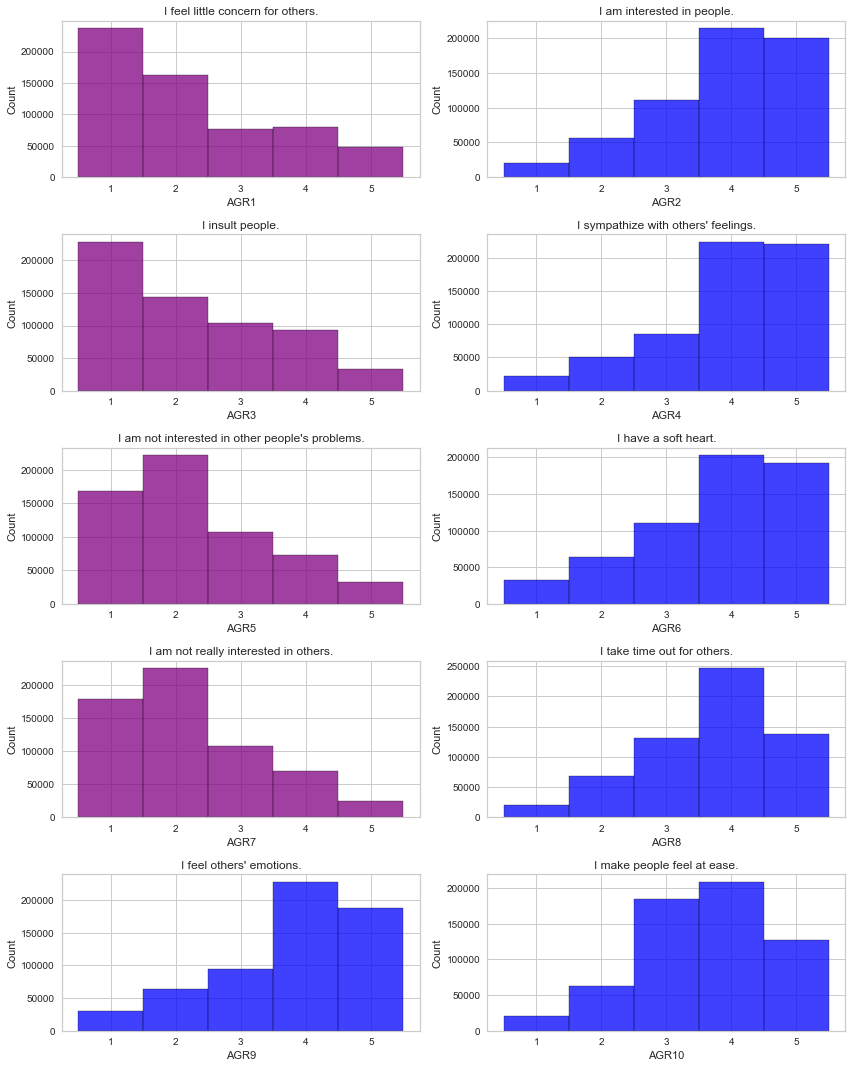

In [9]:
#Plotting Answers to Agreeableness Questions:

keys = list(agreeableness.keys())
#Binning values so distributions fit:
bins = [.5,1.5,2.5,3.5,4.5,5.5]

plt.figure(figsize = (12,15))
for count, i in enumerate(keys):
    #Setting Color for Regular Questions:
    if i in reverse_coded:
        rs = 'purple'
    #Setting Color for Reverse-Coded Questions;
    else:
        rs = 'blue'
    #Organizing Plots Into 5 Rows and Two Columns:
    plt.subplot(5, 2, count + 1)
    #Drawing histogram of distributions, binned to set columns on integers, and colored to show revers-coding:
    sns.histplot(data = df[i].astype(int), bins=bins, color = rs).set(title = agreeableness[i]);

#Grouping plots neatly in final layout:
plt.tight_layout();

#### Neuroticism ('Emotional Stability'):

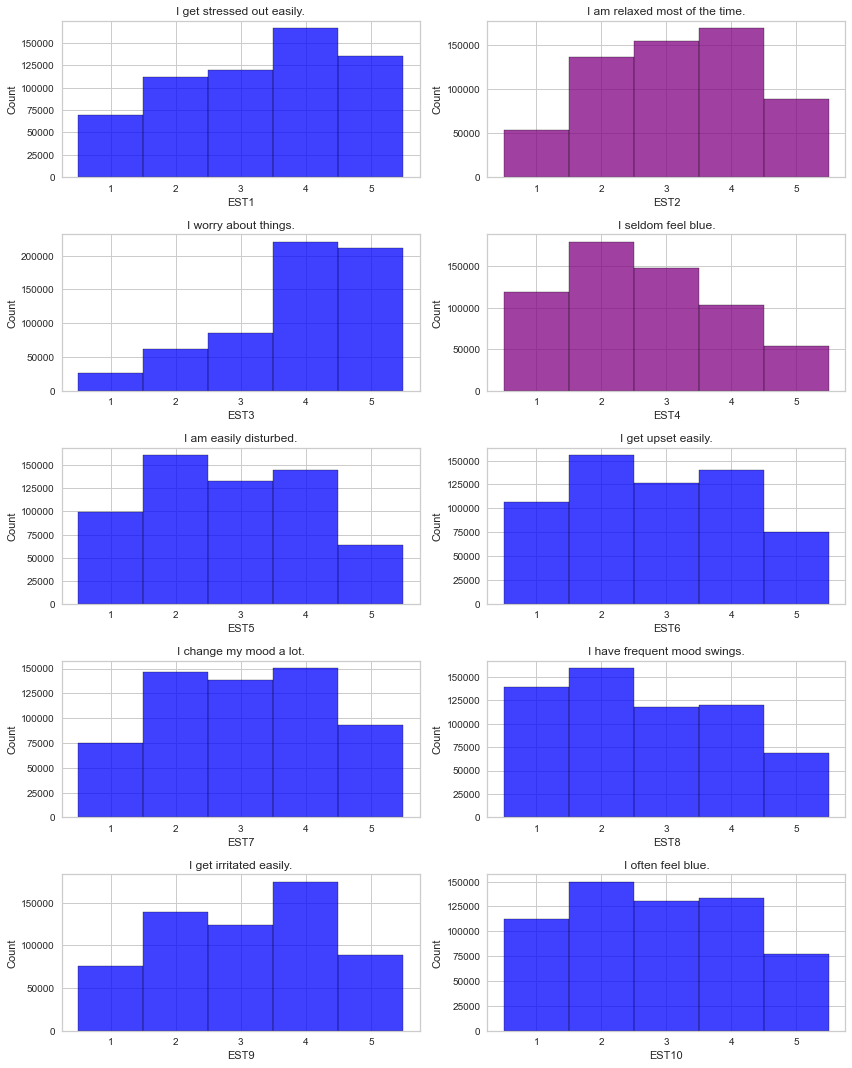

In [10]:
#Plotting Answers to Neuroticism Questions:

keys = list(neuroticism.keys())
#Binning values so distributions fit:
bins = [.5,1.5,2.5,3.5,4.5,5.5]

plt.figure(figsize = (12,15))
for count, i in enumerate(keys):
    #Setting Color for Regular Questions:
    if i in reverse_coded:
        rs = 'purple'
    #Setting Color for Reverse-Coded Questions;
    else:
        rs = 'blue'
    #Organizing Plots Into 5 Rows and Two Columns:
    plt.subplot(5, 2, count + 1)
    #Drawing histogram of distributions, binned to set columns on integers, and colored to show revers-coding:
    sns.histplot(data = df[i].astype(int), bins=bins, color = rs).set(title = neuroticism[i]);

#Grouping plots neatly in final layout:
plt.tight_layout();

#### Visualizing the Mean Value by Metric Across Dataset:
Used an [explore script](https://github.com/greg-maggard/big_5_project/blob/main/explore.py) to calculate the mean for each metric across the dataset, then create a DataFrame of the means and their corresponding metrics.

Takeaway:
- On average, respondents were lower in extroversion and neuroticism, slightly higher in conscientiousness and agreeableness, and highest in openness to experience.

In [11]:
#Calculating means of each metric and generating a dataframe of each metric and its corresponding value:
metric_means_df = explore.metric_means(df)

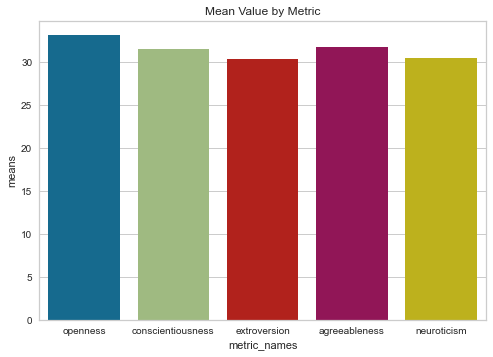

In [12]:
#Creating a barplot to show the mean value of each metric across the dataset:
sns.barplot(data = metric_means_df, x = metric_means_df['metric_names'], y = metric_means_df['means']).set(title = 'Mean Value by Metric')
#Setting the figure size larger for visibility:
sns.set(rc = {'figure.figsize':(15,8)});

#### Creating a Correlation Plot to Visualize General Relationships Between Metrics:
First step is to use a function from the explore script to undo the reverse-coding for better correlation visualization.

Takeaways:
- Although heatmaps are arguably too 'busy' to make for good visualization, this one does allow one to see the relationships between metrics.
    - Interestingly, we can see that the questions for extroversion all seem to correlate with one another well, indicating that these statements are accurately measuring the same thing. 
    - In contrast, we can see that other metrics, mainly conscientiousness and openness, seem to have less strongly correlated statements internally, indicating that these statements are perhaps not as good at measuring the same thing as one another. 
- We can see some interesting correlations between metrics:
    - Agreeableness and Extroversion seem to have a fairly high positive correlation.
    - Openness and Extroversion seem to have a slight positive correlation.
    - Conscientiousness and Neuroticism ('Emotional Stability') seem to be somewhat negatively correlated, particulary visible with the CS4 question: "I make a mess of things." 
    - Neuroticism and Extroversion appear to be slightly negatively correlated overall. 

In [16]:
#Undoing reverse-coding by subtracting all values from the highest + 1 and overwriting the values to flip them:
df = explore.undo_reverse_scoring(df)

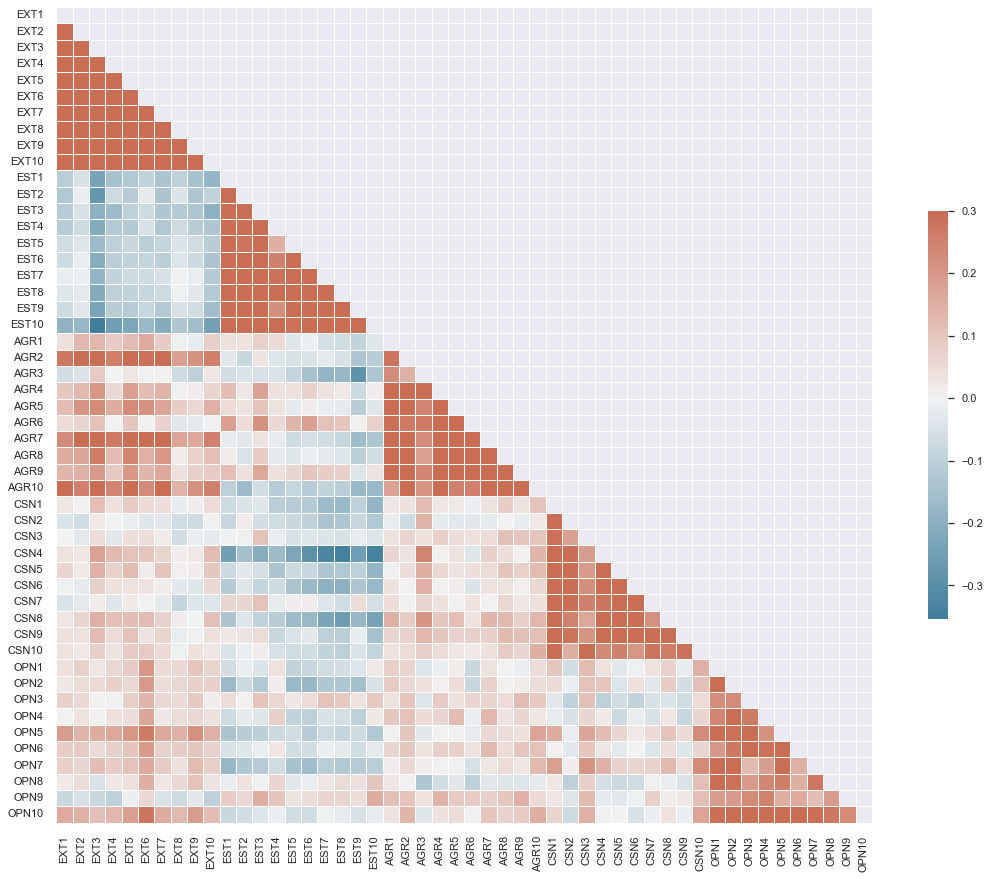

In [15]:
#Computing correlations between columns in dataset:
corr = df.corr()
#Adjusting figure size for visibility:
f, ax = plt.subplots(figsize=(20, 15))
#Creating the mask variable to cut the correlation plot in half for visibility:
mask = np.triu(np.ones_like(corr, dtype=bool))
#Defining a diverging color palette to show the negative to positive correlations:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#Creating the heatmap of the pairwise correlations between the columns, adjusting color and spacing for visibility:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Modeling:

### Pre-Processing for Modeling:
Rather than perform clustering on 50 columns to measure 5 metrics, I summed up all the values within each metric and did the clustering on a DataFrame containing metric total scores for each metric, for each user. This results in much cleaner and tighter clusters.

In [20]:
#Creating a DataFrame of the total for each metric, for each respondent:
metric_totals_df = model.metric_condensation(df)

#### Identifying Optimal Number of Clusters:
First step is to use the KElbowVisualizer from scikit-learn to determine the best number of clusters.

- The KElbowVisualizer shows that the optimal number of clusters will be 5.

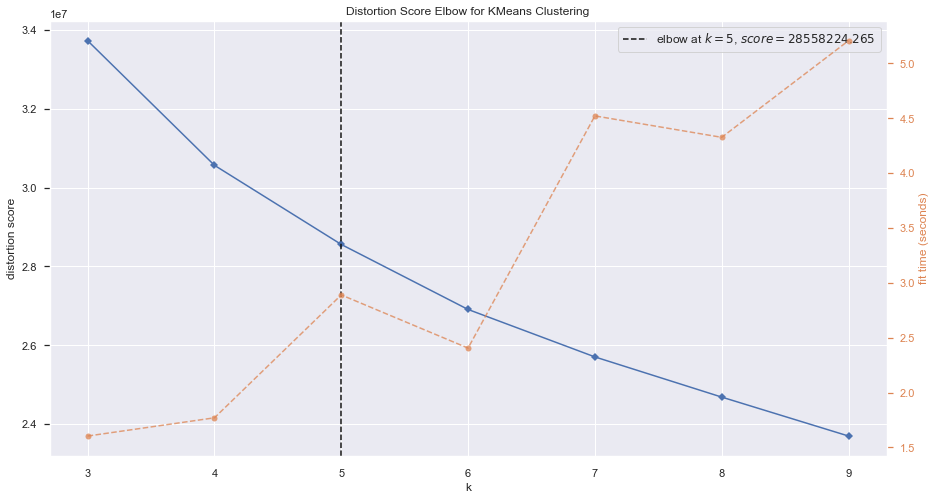

In [22]:
#Creating the Object, checking 3-12 as values for k, and displaying fit time:
elbow_plot = KElbowVisualizer(KMeans(), k=(3,10), timings= True)
#Fitting the object to the metric_totals_df data:
elbow_plot.fit(metric_totals_df)
#Displaying the graph:
elbow_plot.show();

#### Performing Clustering on the Data:

First step will be to create the model object, run it, and then tack on the model's cluster prediction onto a copy of the metric totals DataFrame. That way we have our scores for each respondent, paired with our model's guess about the cluster to which they belong.

In [24]:
#Creating the model object and fitting it to the data:
kmeans = KMeans(n_clusters=5)
kmeans.fit(metric_totals_df)

#Generating predictions with fitted model:
cluster = kmeans.predict(metric_totals_df)

#Duping metric_totals_df and adding cluster:
metric_clusters = metric_totals_df.copy()
metric_clusters['cluster'] = kmeans.predict(metric_totals_df)

#### Visualizing the Clusters:

In order to visualize this easily, the number of dimensions in the data will need to be reduced using principal component analysis, or PCA. This clusters the respondents by how closely they correlate to one another. It is important to run PCA on the *original* metric_totals_df dataframe, rather than the one that includes the cluster prediction, so that the prediction is not seen as a value to be compared.

In [29]:
# Creating PCA object with two variables:
pca = PCA(n_components=2)
# Fitting the PCA to the metric_totals data:
pca_data = pca.fit_transform(metric_totals_df)

#Creating a DataFrame from the PCA output:
pca_data = pd.DataFrame(data=pca_data, columns=['PCA1', 'PCA2'])
#Adding the K-Means model's guessed cluster to each user, now that PCA is complete:
pca_data['cluster'] = kmeans.predict(metric_totals_df)

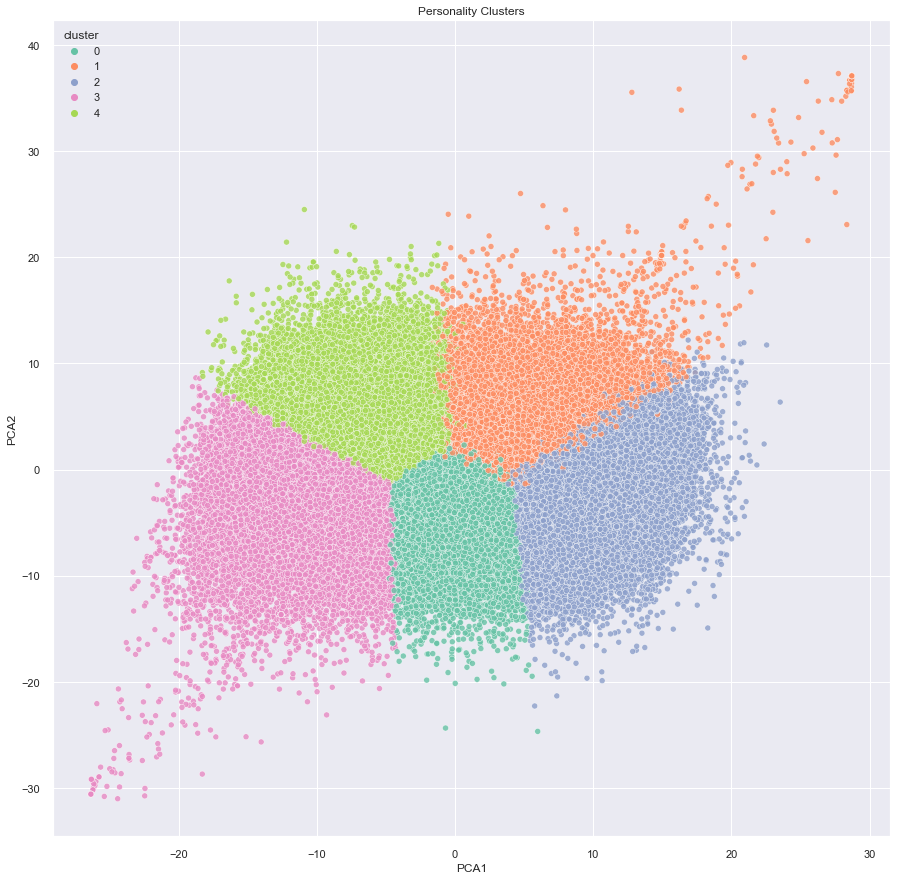

In [30]:
#Setting the figure size for visibility:
plt.figure(figsize=(15,15))
#Creating a scatterplot that uses the PCA data and differentiates the clusters with color:
sns.scatterplot(data=pca_data, x='PCA1', y='PCA2', hue='cluster', palette='Set2', alpha=0.8)
#Setting the title of the graph:
plt.title('Personality Clusters');

# Conclusion:

Throughout the course of this project, it was interesting to see the relationships between different aspects of the questionnaire. Naturally, it was expected to find similarities or differences between combinations of the overall metrics. However, potentially just as interested was the finding that there were even differences in the correlations between questions on the <b>same</b> metric, indicating that perhaps the questions were not all adequately measuring the same thing. 

The K-Means clustering algorithm showed that, rather appropriately, there are potentially five personality groupings that are revealed by the Big 5 personality test. Although clustering does not allow us to make predictions in the way that a supervised machine learning model might, it does provide some visibility into how we might categorize personality types according to Big 5 data. 

#### Going Forward:

Given more time, I would like to continue to refine this project. 
- These groupings are not easily labeled, although it may ultimately prove worthwhile to try to find the average response across the multiple metrics for each cluster, and try to manually label each personality grouping based on those findings. 
- It would be interesting to try to build in some functionality that would allow an individual to provide answers to the questionnaire, and immediately see the cluster to which the model thinks they should be assigned. 
- If time and resources were no object, I would love to do something similar with another personality test, perhaps the MBTI, and see how those already-defined personality classifications correlate with the clusters provided by this model. 
- I would also love to look into the reliability and validity of the test itself. My background in Psychology left me with the knowledge that the BIg 5 is one of the more trustworthy personality metrics, yet it was interesting to see that some of the questions even within the same metric did not appear to correlate with one another as one might think they should. 